In [38]:
# to get mnist hand written character data
from torchvision import datasets
# turn image data into tensor R^n 'matrix'
from torchvision.transforms import ToTensor

In [39]:
# create a subset of the full dataset for training
train_data = datasets.MNIST(
  root= " data", 
  train = True, 
  transform = ToTensor(),
  download = True,
)

# create a subset of the full dataset for testing
test_data = datasets.MNIST(
  root= " data", 
  train = False, 
  transform = ToTensor(),
  download = True,
)

In [40]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location:  data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [41]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location:  data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [42]:
train_data.data.shape
train_data.data.size()

torch.Size([60000, 28, 28])

In [43]:
train_data.targets.shape
train_data.targets.size()

torch.Size([60000])

In [44]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [45]:
from torch.utils.data import DataLoader


# a thing that spits out tiny bits of the dataset when asked
loaders = {
  "train": DataLoader(train_data,
                      batch_size = 100,
                      shuffle=True,
                      num_workers=1,),

  "test": DataLoader(test_data,
                     batch_size=100,
                     shuffle=True,
                     num_workers=1,),
}

In [46]:
# defining the layers of the model, aka the architecture

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# class Net():
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    # regularization
    self.conv2_drop = nn.Dropout2d()
    # dense layer, fully connected layer
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)

    # softmax, final probabilities
    return F.softmax(x)


In [47]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
  # set model to train mode
  model.train()

  for batch_idx, (data, target) in enumerate(loaders["train"]):
    data, target = data.to(device), target.to(device)
    # zero gradients in optimizer
    optimizer.zero_grad()
    # make a prediction - forward pass
    output = model(data)
    # calculate performance
    loss = loss_fn(output, target)
    # backpropagation 
    loss.backward()
    # do a step of the optimizer
    optimizer.step()

    if batch_idx % 20 == 0:
      print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')

def test():
  model.eval()

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in loaders['test']:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += loss_fn(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()


  test_loss /= len(loaders['test'].dataset)
  print(f'/nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%\n)')
  

In [48]:
for epoch in range(1, 11): 
  train(epoch)
  test()

/tmp/ipykernel_21426/1710167421.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	2.304131
Train Epoch: 1 [2000/60000 (3%)]	2.290982
Train Epoch: 1 [4000/60000 (7%)]	2.222322
Train Epoch: 1 [6000/60000 (10%)]	1.993485
Train Epoch: 1 [8000/60000 (13%)]	1.920708
Train Epoch: 1 [10000/60000 (17%)]	1.858778
Train Epoch: 1 [12000/60000 (20%)]	1.845053
Train Epoch: 1 [14000/60000 (23%)]	1.827843
Train Epoch: 1 [16000/60000 (27%)]	1.750437
Train Epoch: 1 [18000/60000 (30%)]	1.728356
Train Epoch: 1 [20000/60000 (33%)]	1.645761
Train Epoch: 1 [22000/60000 (37%)]	1.681920
Train Epoch: 1 [24000/60000 (40%)]	1.678167
Train Epoch: 1 [26000/60000 (43%)]	1.698497
Train Epoch: 1 [28000/60000 (47%)]	1.647012
Train Epoch: 1 [30000/60000 (50%)]	1.640061
Train Epoch: 1 [32000/60000 (53%)]	1.652180
Train Epoch: 1 [34000/60000 (57%)]	1.621520
Train Epoch: 1 [36000/60000 (60%)]	1.638308
Train Epoch: 1 [38000/60000 (63%)]	1.612177
Train Epoch: 1 [40000/60000 (67%)]	1.683077
Train Epoch: 1 [42000/60000 (70%)]	1.599600
Train Epoch: 1 [44000/60000 (73%)]	1.662632

In [56]:
device

device(type='cuda')

Prediction: 7


/tmp/ipykernel_21426/1710167421.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


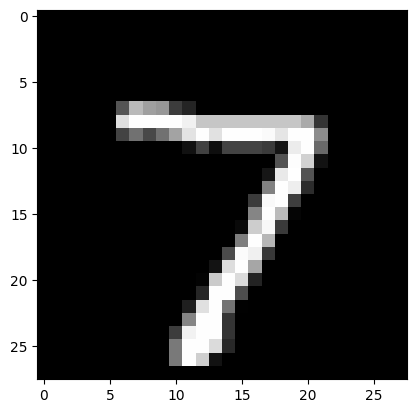

In [60]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[0]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0). squeeze(0).cpu().numpy()

plt.imshow(image, cmap="gray")
plt.show()